In [878]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from thermography_dataset import ThermDataset
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Parameters 

In [879]:
args = {'main lr':0.01,
        'nested lr':0.001,
        'batch_size':32,
        'main epochs':500,
        'pretrain epochs': 500,
        'noise':0.001,
        'train_size':0.7,
        }

# Prepare Data

In [880]:
dataset = ThermDataset(fp='combined_data.xlsx', direction=0, noise_scale=args['noise'], tandem=1)

In [881]:
train_size = int(args['train_size'] * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [882]:
nested_loader = DataLoader(dataset, shuffle=True, batch_size=args['batch_size'])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=args['batch_size'])
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=args['batch_size'])

# Design Model 
(input size, output size, forward pass)

In [883]:
# temp in spec out
class SubNN(nn.Module):
    def __init__(self, spec_size, temp_size):
        super(SubNN, self).__init__()
        self.lin1 = nn.Linear(temp_size, 20)
        self.lin2 = nn.Linear(20, 40)
        self.lin3 = nn.Linear(40, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, spec_size)


    def forward(self, x):
        spec_pred = F.leaky_relu(self.lin1(x))
        spec_pred = F.leaky_relu(self.lin2(spec_pred))
        spec_pred = F.leaky_relu(self.lin3(spec_pred))
        spec_pred = F.leaky_relu(self.lin4(spec_pred))
        spec_pred = self.lin_fin(spec_pred)
        return spec_pred

In [884]:
# spec in spec out
class MainNN(nn.Module):
    def __init__(self, temp_size, spec_size):
        super(MainNN, self).__init__()
        self.subnet = SubNN(spec_size=spec_size, temp_size=temp_size) # temp in spec out
        self.lin1 = nn.Linear(spec_size, 45) 
        self.lin2 = nn.Linear(45, 45)
        self.lin3 = nn.Linear(45, 45)
        self.lin_fin = nn.Linear(45, temp_size)

    def forward(self, x):
        temp_pred = F.leaky_relu(self.lin1(x))
        temp_pred = F.leaky_relu(self.lin2(temp_pred))
        temp_pred = F.leaky_relu(self.lin3(temp_pred))
        temp_pred = self.lin_fin(temp_pred)
        
        spec_pred = self.subnet(temp_pred)

        return spec_pred, temp_pred

In [885]:
n_samples = len(train_dataset)
_, temp_size = dataset.x.shape
_, spec_size = dataset.y.shape

main_model = MainNN(temp_size=temp_size, spec_size=spec_size)
nested_model = SubNN(temp_size=temp_size, spec_size=spec_size)

# Construct Loss and Optimizer

In [886]:
nested_learning_rate = args['nested lr']
main_learning_rate = args['main lr']
criterion = nn.L1Loss()
main_optimizer = torch.optim.Rprop(main_model.parameters(), lr=main_learning_rate)
nested_optimizer = torch.optim.Rprop(nested_model.parameters(), lr=nested_learning_rate)

# Training Loop

In [887]:
# pretrain loop
num_epochs = args['pretrain epochs']
loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for temp_batch, spec_batch in train_loader:
        # empty gradients
        nested_optimizer.zero_grad()
        
        # forward pass and loss
        spec_pred = nested_model(temp_batch)
        loss = criterion(spec_pred, spec_batch)

        # backward pass
        loss.backward()

        # update
        nested_optimizer.step()


    loss_list.append(loss.item())

    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss}')

print(f'\nbest loss: {best_loss} in epoch: {best_epoch}')

epoch: 50, loss = 0.15055520832538605
epoch: 100, loss = 0.22693811357021332
epoch: 150, loss = 0.27489399909973145
epoch: 200, loss = 0.1807219535112381
epoch: 250, loss = 0.2971000671386719
epoch: 300, loss = 0.24035611748695374
epoch: 350, loss = 0.20055294036865234
epoch: 400, loss = 0.24632343649864197
epoch: 450, loss = 0.16079100966453552
epoch: 500, loss = 0.29315105080604553

best loss: 0.06840178370475769 in epoch: 75


In [888]:
# freeze weights
for param in main_model.subnet.parameters():
    param.requires_grad = False

In [889]:
# main loop
num_epochs = args['main epochs']
loss_list = []
temp_loss_list = []
tand_loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for temp_batch, spec_batch in train_loader:        
        # empty gradients
        main_optimizer.zero_grad()

        # forward pass and loss
        spec_pred, temp_pred = main_model(spec_batch)

        # get loss
        tand_loss = criterion(spec_pred, spec_batch)
        temp_loss = criterion(temp_pred, temp_batch)
        total_loss = tand_loss + temp_loss

        # backward pass
        if (epoch+1) > num_epochs*.35:
            temp_loss.backward()
        else:
            tand_loss.backward()

        # update
        main_optimizer.step()

        

    loss_list.append(temp_loss.item())
    tand_loss_list.append(tand_loss.item())
    temp_loss_list.append(temp_loss.item())

    if temp_loss < best_loss:
        best_loss = temp_loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, tandem loss = {tand_loss:.6f}, temperature loss = {temp_loss:.6f}')

print(f'\nbest temperature loss: {best_loss:.3f} in epoch: {best_epoch}')

epoch: 50, tandem loss = 2.189423, temperature loss = 327.227142
epoch: 100, tandem loss = 1.456075, temperature loss = 329.362915
epoch: 150, tandem loss = 2.071917, temperature loss = 330.651917
epoch: 200, tandem loss = 3.571327, temperature loss = 8.568796
epoch: 250, tandem loss = 3.363175, temperature loss = 10.852240
epoch: 300, tandem loss = 3.103084, temperature loss = 8.719186
epoch: 350, tandem loss = 3.069714, temperature loss = 8.287652
epoch: 400, tandem loss = 3.113195, temperature loss = 7.775410
epoch: 450, tandem loss = 3.024150, temperature loss = 11.293910
epoch: 500, tandem loss = 3.511030, temperature loss = 8.148215

best temperature loss: 5.390 in epoch: 445


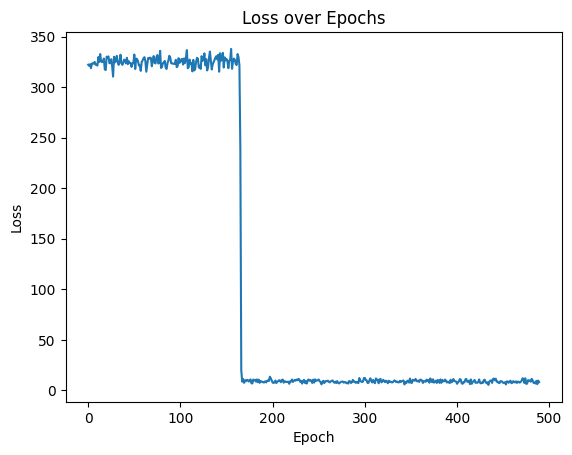

In [890]:
#plt.plot(loss_list, label='total loss')
#plt.plot(spec_loss_list[20:], label='spectrum loss')
plt.plot(temp_loss_list[10:], label='temperature loss')

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [891]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index, prediction):
    actual_np = actual[index]
    pred_np = pred[index]

    if prediction == 'spec':
        plt.title("Thermel-Emission Spectrum")
        plt.xlabel("Wavlength (m)")
        plt.ylabel("Intensity")
        pred_np = pred_np * (10**-12)
        actual_np = actual_np * (10**-12)
        wavelengths = dataset.wavelengths * (10**-3)
        plt.plot(wavelengths, actual_np, label='actual')
        plt.plot(wavelengths, pred_np, 'r+', label='predicted')
    else:
        plt.title("Temperature Distribution")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")
        x = np.arange(1, 12, 1)
        plt.plot(x, actual_np, label='actual')
        plt.plot(x, pred_np, 'r+', label='predicted')
        plt.xticks(np.arange(min(x), max(x)+1, 1.0))

    

    plt.legend()
    plt.show()

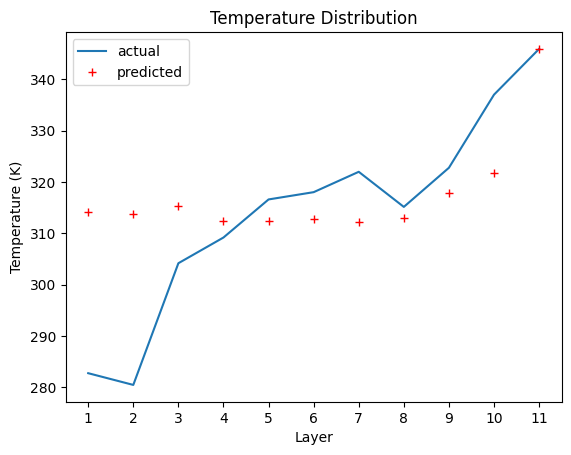

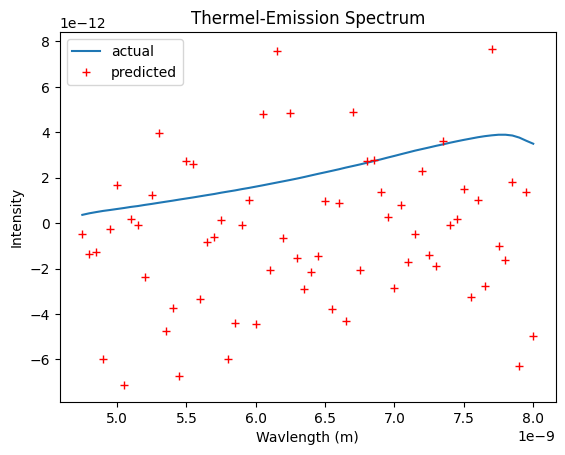

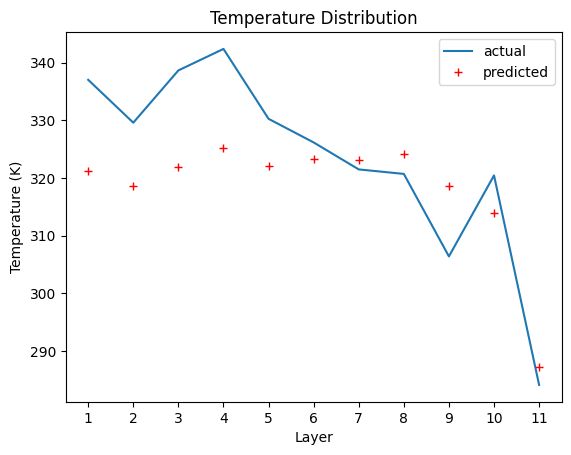

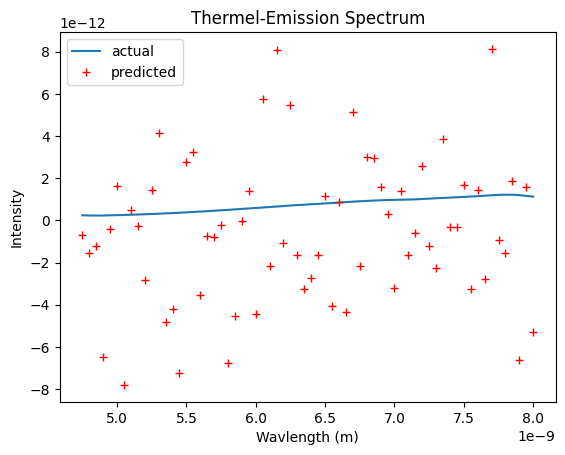

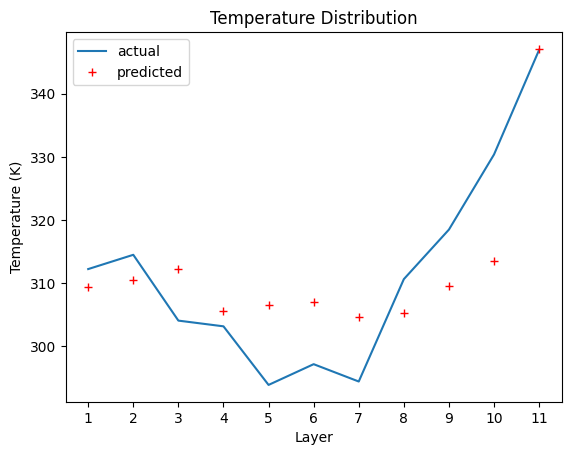

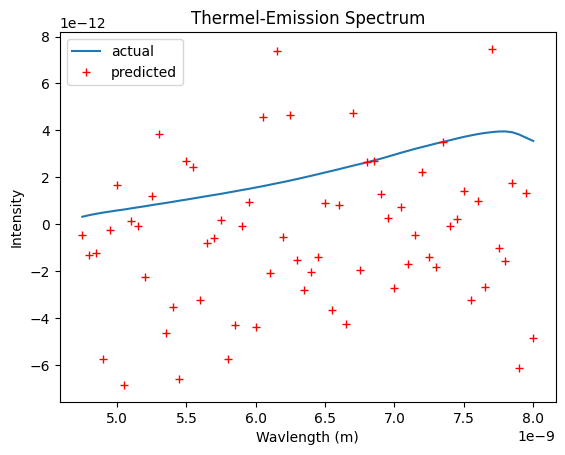

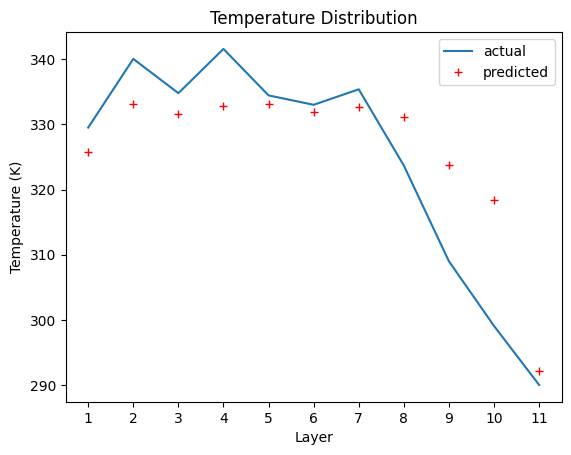

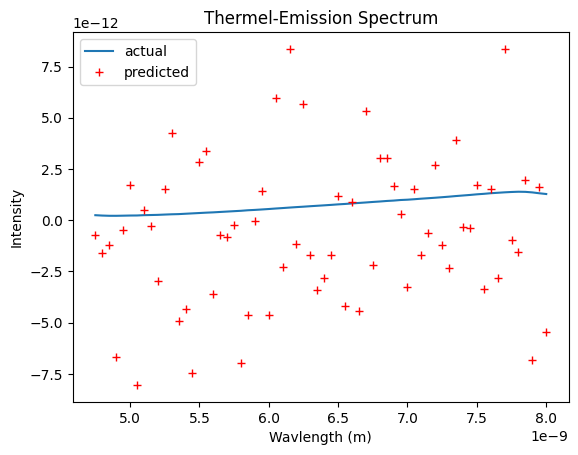

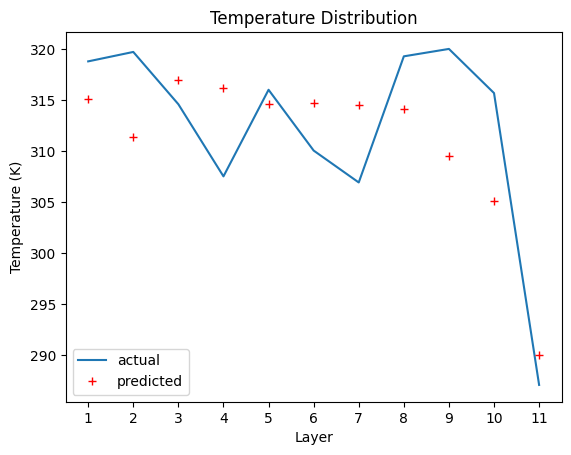

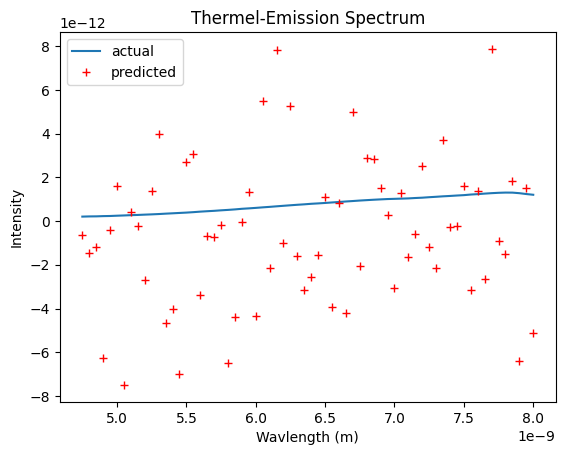

average temperature loss: 8.784
average spectrum loss: 3.381069


In [892]:
total_temp_loss = 0
total_spec_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0


with torch.no_grad():
    for temp_batch, spec_batch in test_loader:
        spec_pred, temp_pred = main_model(spec_batch)
        
        temp_loss = criterion(temp_pred, temp_batch)
        total_temp_loss += temp_loss.item() * len(temp_batch)

        spec_loss = criterion(spec_pred, spec_batch)
        total_spec_loss += spec_loss.item() * len(spec_batch)

        n_samples += len(temp_batch)
        current_batch += 1

        if current_batch % int(total_batches/5) == 0:
            plot_actual_vs_pred(temp_pred.numpy(), temp_batch.numpy(), 0, prediction='temp') 
            plot_actual_vs_pred(spec_pred.numpy(), spec_batch.numpy(), 0, prediction='spec')

average_temp_loss = total_temp_loss/n_samples
average_spec_loss = total_spec_loss/n_samples
print(f"average temperature loss: {average_temp_loss:.3f}\naverage spectrum loss: {average_spec_loss:.6f}")